## <center> AGE OF EMPIRES II: DE PATCH 47820</center>

![46295](https://static.ageofempires.com/aoe/wp-content/uploads/2021/04/AgeOfEmpires_2DE_UPDATE_2021.jpg)

### ANÁLISIS EXPLORATORIO DE LOS DATOS.

#### LIBRERÍAS UTILIZADAS.

In [1]:
## Importación de datos.
from sqlalchemy import create_engine

## Tratamiento de datos.
import pandas as pd
import numpy as np

## Gráficos.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10

## Configuración warnings.
import warnings
warnings.filterwarnings('ignore')

#### QUERY A LA BBDD DE MARIADB.

In [2]:
# Nombre de usuario, contraseña y BBDD MySQL.
mysql_address = '172.30.248.86'
mysql_port = '3306'
mysql_username = 'mms'
mysql_password = 'agedb'
mysql_dbname = 'aoe2de'

# String que contiene la información necesaria para el login de MySQL.
mysql_str = ('mysql+pymysql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username = mysql_username,
password = mysql_password,
ipaddress = mysql_address,
port = mysql_port,
dbname = mysql_dbname))

In [3]:
# Query para importar los datos desde MySQL.
cnx = create_engine(mysql_str)
query = f"""
SELECT
        matches.match_id,
        matches.version,
        matches.map_size,
        matches.map_type,
        matches.rating_type,
        matches.server,
        matches.duration_minutes,
        players.profile_id,
        players.player_name,
        players.country,
        players.rating,
        players.color,
        players.team,
        players.civ,
        players.won
FROM
    matches, players
WHERE
    matches.match_id = players.match_id
AND
    matches.version = '47820';
"""
df = pd.read_sql_query(query, con=cnx)
df.shape

(5777426, 15)

#### PREVISUALIZACIÓN DEL DATASET.

In [4]:
# Observamos los primeros 10 valores para ver que se han cargado correctamente.
df.head(10)

,match_id,version,map_size,map_type,rating_type,server,duration_minutes,profile_id,player_name,country,rating,color,team,civ,won
0,88924648,47820,Large (8 player),Arabia,Team Random Map,eastus,17,298828,LHK | Ramiro,CL,1378.0,cyan,2,Ethiopians,0
1,88924648,47820,Large (8 player),Arabia,Team Random Map,eastus,17,1686646,m¡rko,CH,1394.0,blue,2,Lithuanians,0
2,88924648,47820,Large (8 player),Arabia,Team Random Map,eastus,17,1833984,p.preisig,CH,1384.0,green,2,Burgundians,0
3,88924648,47820,Large (8 player),Arabia,Team Random Map,eastus,17,1961475,Manteca Martinez,AR,1529.0,yellow,1,Persians,1
4,88924648,47820,Large (8 player),Arabia,Team Random Map,eastus,17,1983146,the ocho,AR,1495.0,purple,1,Malians,1
5,88924648,47820,Large (8 player),Arabia,Team Random Map,eastus,17,2122225,R-Garín DRL,CL,1376.0,orange,2,Mongols,0
6,88924648,47820,Large (8 player),Arabia,Team Random Map,eastus,17,3985800,garagona,AR,1747.0,grey,1,Britons,1
7,88924648,47820,Large (8 player),Arabia,Team Random Map,eastus,17,5681681,bombabombaestoy,AR,NaN,red,1,Mayans,1
8,88924659,47820,Medium (4 player),Arabia,Team Random Map,eastus,24,11679,HighFlyer,CA,2787.0,green,2,Burgundians,1
9,88924659,47820,Medium (4 player),Arabia,Team Random Map,eastus,24,280622,Skritshell,CA,2978.0,blue,2,Britons,1


In [5]:
# Comprobación de valores NaN en el dataset.
df.isna().sum()

match_id                 0
version                  0
map_size                 0
map_type                 0
rating_type              0
server                   0
duration_minutes         0
profile_id               0
player_name            164
country             322266
rating              252380
color                    7
team                     0
civ                      0
won                      0
dtype: int64

In [6]:
# Rellenar valores vacíos de las varibales "color" y "country".
df.color.fillna("unknown", inplace=True)
df.country.fillna("UNKNOWN", inplace=True)

In [7]:
# Dividir dataframe df en partidas single player y en partidas multiplayer.
df_singleplayer = df[df["rating_type"]=="1v1 Random Map"]
# df_singleplayer.rating.fillna(df_singleplayer.rating.mean(), inplace=True)
df_multiplayer = df[df["rating_type"]=="Team Random Map"]
# df_multiplayer.rating.fillna(df_multiplayer.rating.mean(), inplace=True)

In [8]:
total_partidas                          = len(df.match_id.unique())
total_partidas_singleplayer = len(df_singleplayer.match_id.unique())
total_partidas_multiplayer   = len(df_multiplayer.match_id.unique())
porcentaje_partidas_singleplayer = round(total_partidas_singleplayer/total_partidas, 2)
porcentaje_partidas_multiplayer   = round(total_partidas_multiplayer/total_partidas, 2)
print("Total partidas: " + str(total_partidas))
print("Total partidas 1v1: " + str(total_partidas_singleplayer))
print("Total partidas multi jugador: " + str(total_partidas_multiplayer))
print("Porcentaje partidas 1v1 sobre total: " + str(porcentaje_partidas_singleplayer))
print("Porcentaje partidas multi jugador sobre total: " + str(porcentaje_partidas_multiplayer))

Total partidas: 1715174
Total partidas 1v1: 1076839
Total partidas multi jugador: 638335
Porcentaje partidas 1v1 sobre total: 0.63
Porcentaje partidas multi jugador sobre total: 0.37


#### Civilizaciones.

In [9]:
# Obtener los valores únicos de la variable "civ".
sorted_civs = df_singleplayer.civ.unique().tolist()
sorted_civs.sort()

In [10]:
def get_frequency_rates_by_civ(df):
    return pd.DataFrame(df.civ.value_counts(normalize=True)).reset_index().rename(columns={"index": "civ", "civ": "frequency"})

In [11]:
frequency_civs_singleplayer, frequency_civs_multiplayer = get_frequency_rates_by_civ(df_singleplayer), get_frequency_rates_by_civ(df_multiplayer)

In [12]:
def get_win_rates_by_civ(df):
    return (
        df.groupby("civ")["won"]
            .mean()
            .reset_index()
            .rename(columns={"won": "win_rate"})
            .sort_values("win_rate", ascending=False)
            .reset_index(drop=True)
    )

In [13]:
winrate_civs_singleplayer, win_rate_civs_multiplayer = get_win_rates_by_civ(df_singleplayer), get_win_rates_by_civ(df_multiplayer)

#### Mapas.

In [14]:
# Obtener los valores únicos de la variable "map_type".
sorted_maps = df_singleplayer.map_type.unique().tolist()
sorted_maps.sort()

In [15]:
def get_frequency_rates_by_map(df):
    return pd.DataFrame(df.map_type.value_counts(normalize=True)).reset_index().rename(columns={"index": "map", "map_type": "frequency"})

In [16]:
frequency_maps_singleplayer, frequency_maps_multiplayer = get_frequency_rates_by_map(df_singleplayer), get_frequency_rates_by_map(df_multiplayer)

#### Colores.

In [17]:
# Obtener los valores únicos de la variable "color".
sorted_colors = df_singleplayer.color.unique().tolist()
sorted_colors.sort()

In [18]:
def get_frequency_rates_by_color(df):
    return pd.DataFrame(df.color.value_counts(normalize=True)).reset_index().rename(columns={"index": "color", "color": "frequency"})

In [19]:
frequency_colors_singleplayer, frequency_color_multiplayer = get_frequency_rates_by_color(df_singleplayer), get_frequency_rates_by_color(df_multiplayer)

#### Servidores.

In [20]:
# Obtener los valores únicos de la variable "server".
sorted_servers = df_singleplayer.server.unique().tolist()
sorted_servers.sort()

In [21]:
def get_frequency_rates_by_server(df):
    return pd.DataFrame(df.server.value_counts(normalize=True)).reset_index().rename(columns={"index": "server", "server": "frequency"})

In [22]:
frequency_server_singleplayer, frequency_server_multiplayer = get_frequency_rates_by_server(df_singleplayer), get_frequency_rates_by_server(df_multiplayer)

#### Países.

In [23]:
# Obtener los valores únicos de la variable "country".
sorted_countries= df_singleplayer.country.unique().tolist()
sorted_countries.sort()

In [24]:
def get_frequency_rates_by_country(df):
    return pd.DataFrame(df.country.value_counts(normalize=True)).reset_index().rename(columns={"index": "country", "country": "frequency"})

In [25]:
frequency_country_singleplayer, frequency_country_multiplayer = get_frequency_rates_by_country(df_singleplayer), get_frequency_rates_by_country(df_multiplayer)

#### ANÁLISIS PARTIDAS 1v1.

In [26]:
# Comprobación de valores NaN de cada variable.
df_singleplayer.isna().sum()

match_id                0
version                 0
map_size                0
map_type                0
rating_type             0
server                  0
duration_minutes        0
profile_id              0
player_name             6
country                 0
rating              86601
color                   0
team                    0
civ                     0
won                     0
dtype: int64

In [27]:
df_singleplayer.describe()

,match_id,version,duration_minutes,profile_id,rating,team,won
count,2.153678e+06,2153678.0,2.153678e+06,2.153678e+06,2.067077e+06,2153678.0,2153678.0
mean,9.585648e+07,47820.0,2.476863e+01,2.544966e+06,1.135337e+03,1.5,0.5
std,3.977841e+06,0.0,1.160572e+01,1.691477e+06,3.020576e+02,0.5,0.5
min,8.892473e+07,47820.0,0.000000e+00,1.530000e+02,0.000000e+00,1.0,0.0
25%,9.244788e+07,47820.0,1.800000e+01,1.070921e+06,9.290000e+02,1.0,0.0
50%,9.578678e+07,47820.0,2.500000e+01,2.374685e+06,1.092000e+03,1.5,0.5
75%,9.936088e+07,47820.0,3.100000e+01,3.744897e+06,1.299000e+03,2.0,1.0
max,1.026707e+08,47820.0,2.400000e+02,6.079998e+06,2.640000e+03,2.0,1.0


Text(0.5, 0, 'ELO')

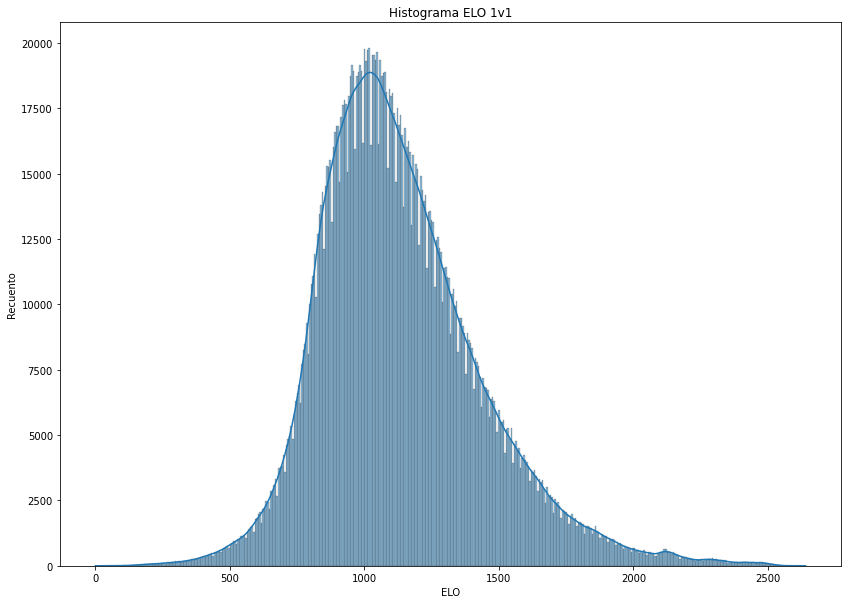

In [28]:
ax = sns.histplot(df_singleplayer.rating, stat="count", kde="True")
ax.set_title('Histograma ELO 1v1')
ax.set_ylabel('Recuento')
ax.set_xlabel('ELO')

<AxesSubplot:xlabel='rating'>

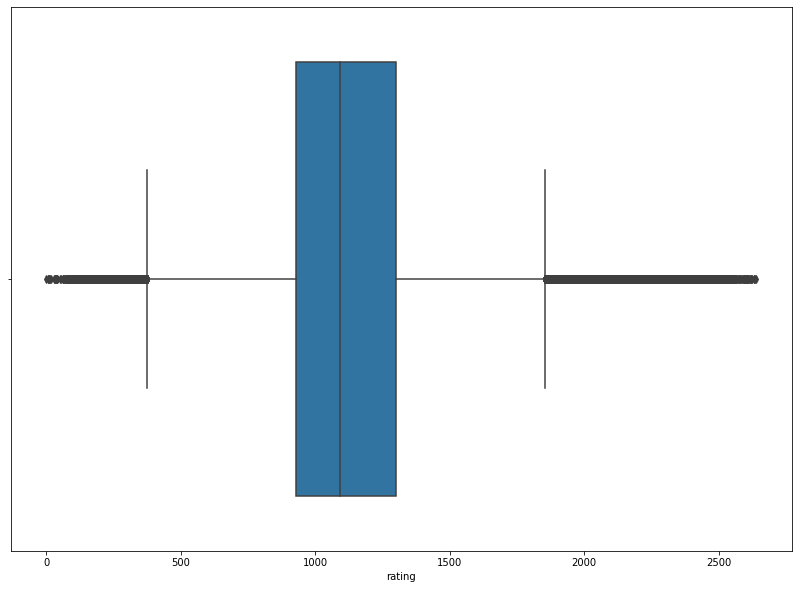

In [29]:
sns.boxplot(df_singleplayer.rating)

Text(0.5, 0, 'Duración en minutos')

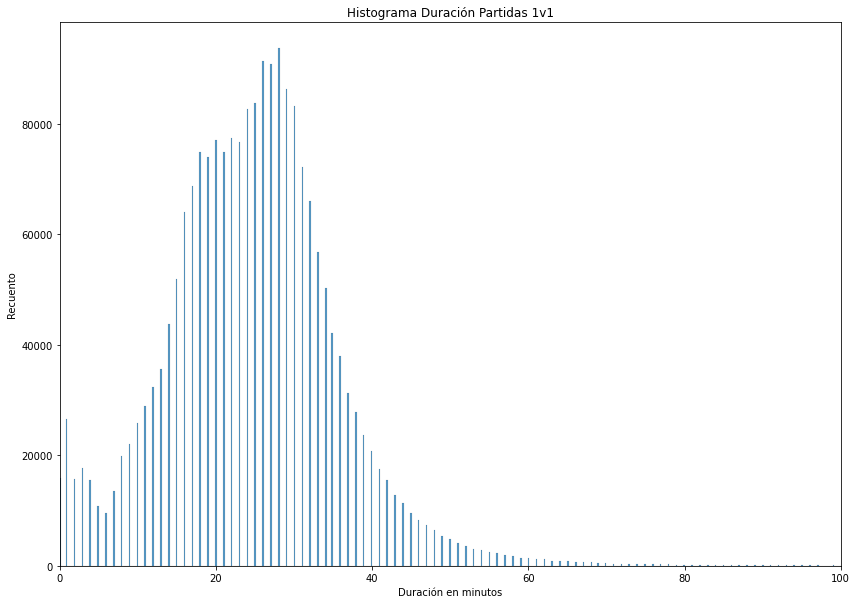

In [30]:
ax = sns.histplot(df_singleplayer.duration_minutes)
plt.xlim(0, 100)
ax.set_title('Histograma Duración Partidas 1v1')
ax.set_ylabel('Recuento')
ax.set_xlabel('Duración en minutos')

<AxesSubplot:xlabel='duration_minutes'>

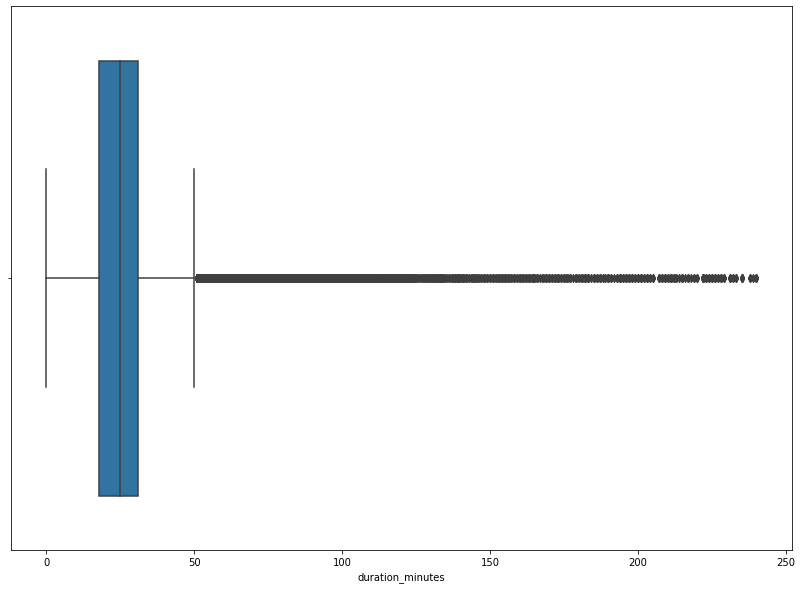

In [31]:
sns.boxplot(df_singleplayer.duration_minutes)

Text(0.5, 1.0, '% de Uso de Civilizaciones en partidas 1v1')

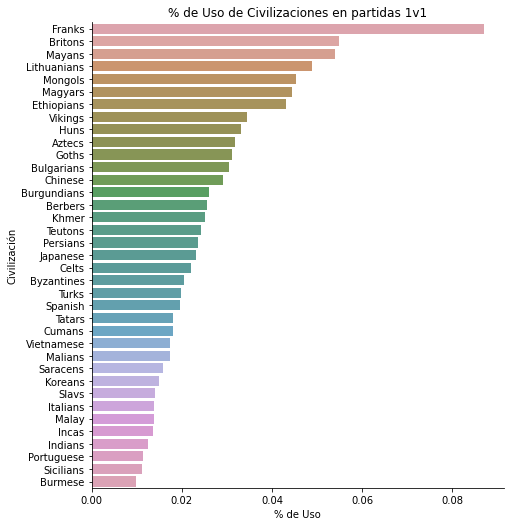

In [32]:
sns.catplot(y="civ", x="frequency",  data=frequency_civs_singleplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Civilización")
plt.xlabel("% de Uso")
plt.title("% de Uso de Civilizaciones en partidas 1v1")

Text(0.5, 1.0, 'Porcentaje de Victorias de Civilizaciones en partidas 1v1')

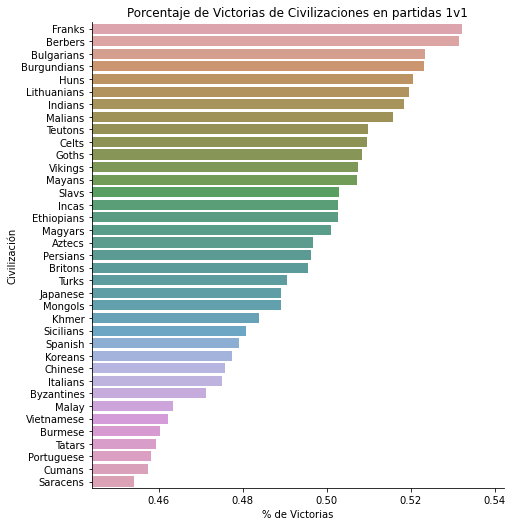

In [33]:
sns.catplot(y="civ", x="win_rate",  data=winrate_civs_singleplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Civilización")
plt.xlabel("% de Victorias")
lim_sup = float(winrate_civs_singleplayer.win_rate.head(1) + 0.01)
lim_inf = float(winrate_civs_singleplayer.win_rate.tail(1) - 0.01)
plt.xlim(lim_inf, lim_sup)
plt.title("Porcentaje de Victorias de Civilizaciones en partidas 1v1")

Text(0.5, 1.0, '% de Partidas por Mapa en partidas 1v1')

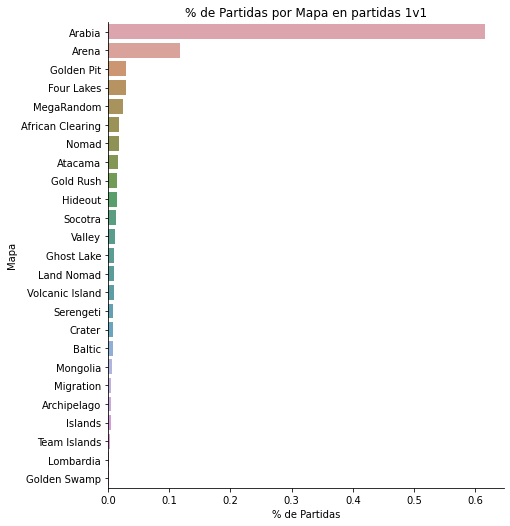

In [34]:
sns.catplot(y="map", x="frequency",  data=frequency_maps_singleplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Mapa")
plt.xlabel("% de Partidas")
plt.title("% de Partidas por Mapa en partidas 1v1")

Text(0.5, 1.0, '% de Partidas por Color en partidas 1v1')

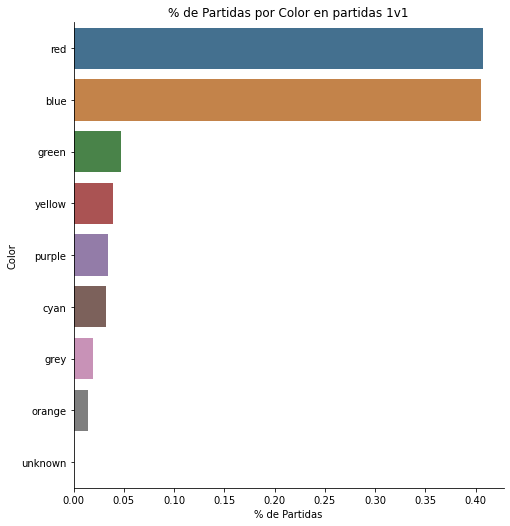

In [35]:
sns.catplot(y="color", x="frequency",  data=frequency_colors_singleplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Color")
plt.xlabel("% de Partidas")
plt.title("% de Partidas por Color en partidas 1v1")

Text(0.5, 1.0, '% de Partidas por Servidor en partidas 1v1')

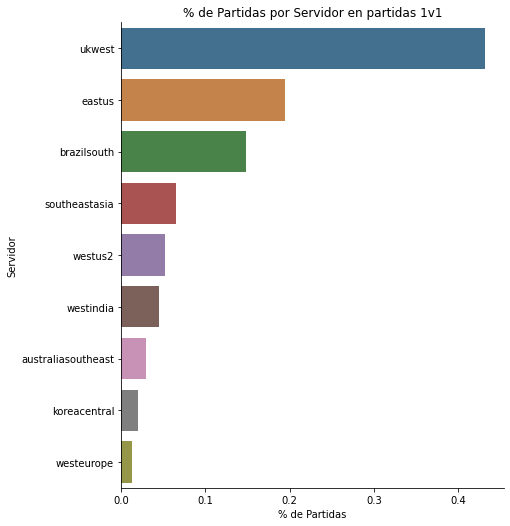

In [36]:
sns.catplot(y="server", x="frequency",  data=frequency_server_singleplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Servidor")
plt.xlabel("% de Partidas")
plt.title("% de Partidas por Servidor en partidas 1v1")

Text(0.5, 1.0, '% de Partidas por Nacionalidad en partidas 1v1')

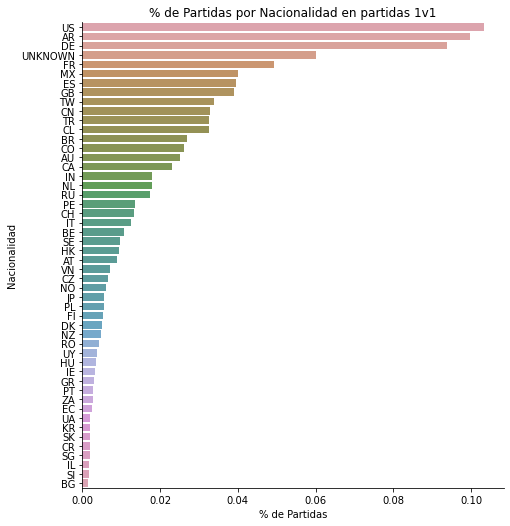

In [37]:
frequency_country_singleplayer = frequency_country_singleplayer.head(50)
sns.catplot(y="country", x="frequency",  data=frequency_country_singleplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Nacionalidad")
plt.xlabel("% de Partidas")
plt.title("% de Partidas por Nacionalidad en partidas 1v1")

In [38]:
renames_singleplayer = {
    "profile_id": "opponent",
    "civ": "opponent_civ",
}
opponents_singleplayer = df_singleplayer[["match_id", "profile_id", "civ"]].rename(columns=renames_singleplayer)
vs_df_singleplayer = pd.merge(df_singleplayer, opponents_singleplayer, left_on="match_id", right_on="match_id").rename(columns={"profile_id": "player"})

# Dado que hemos fusionado el mismo marco de datos un jugador será un oponente de sí mismo, debemos eliminar esas filas.
vs_df_singleplayer = vs_df_singleplayer[vs_df_singleplayer["player"] != vs_df_singleplayer["opponent"]]
vs_df_singleplayer = vs_df_singleplayer[["match_id", "player", "opponent", "civ", "opponent_civ", "won"]]

In [39]:
vs_df_singleplayer.head(6)

,match_id,player,opponent,civ,opponent_civ,won
1,88924731,2031177,2686104,Teutons,Goths,0
2,88924731,2686104,2031177,Goths,Teutons,1
5,88924737,1219666,4272361,Persians,Incas,0
6,88924737,4272361,1219666,Incas,Persians,1
9,88924739,1515640,3550873,Japanese,Goths,1
10,88924739,3550873,1515640,Goths,Japanese,0


In [40]:
# Matriz cuadrada del porcentaje de victorias de civilizaciones vs el resto de civilizaciones.
win_vs_singleplayer = vs_df_singleplayer.pivot_table(values="won", index="civ", columns="opponent_civ")
win_vs_singleplayer.head(10)

opponent_civ,Aztecs,Berbers,Britons,Bulgarians,Burgundians,Burmese,Byzantines,Celts,Chinese,Cumans,...,Portuguese,Saracens,Sicilians,Slavs,Spanish,Tatars,Teutons,Turks,Vietnamese,Vikings
civ,,,,,,,,,,,,,,,,,,,,,
Aztecs,0.500000,0.499697,0.518955,0.400286,0.474128,0.534009,0.567760,0.468099,0.544732,0.528332,...,0.529820,0.553459,0.453865,0.462863,0.518278,0.577362,0.474448,0.496924,0.547251,0.495159
Berbers,0.500303,0.500000,0.542857,0.502085,0.521607,0.562977,0.516634,0.494774,0.533042,0.556678,...,0.560297,0.577297,0.587413,0.495822,0.588057,0.623041,0.508237,0.617045,0.575727,0.516196
Britons,0.481045,0.457143,0.500000,0.487838,0.460535,0.555144,0.536082,0.495779,0.528858,0.530812,...,0.591935,0.598691,0.522605,0.493134,0.536011,0.567437,0.524001,0.491963,0.491344,0.537231
Bulgarians,0.599714,0.497915,0.512162,0.500000,0.513134,0.547112,0.566228,0.564315,0.550325,0.566327,...,0.546243,0.535289,0.580460,0.547368,0.523168,0.520298,0.495530,0.531008,0.596675,0.517401
Burgundians,0.525872,0.478393,0.539465,0.486866,0.500000,0.509632,0.524590,0.495518,0.555425,0.560662,...,0.584084,0.510353,0.562814,0.532357,0.517889,0.553907,0.507493,0.535852,0.579167,0.501394
Burmese,0.465991,0.437023,0.444856,0.452888,0.490368,0.500000,0.495434,0.460084,0.431338,0.537736,...,0.483333,0.484293,0.486891,0.526627,0.474501,0.437659,0.484794,0.476496,0.466042,0.420670
Byzantines,0.432240,0.483366,0.463918,0.433772,0.475410,0.504566,0.500000,0.467871,0.494262,0.515892,...,0.501661,0.518405,0.449807,0.472669,0.509692,0.503338,0.473146,0.446067,0.502003,0.450815
Celts,0.531901,0.505226,0.504221,0.435685,0.504482,0.539916,0.532129,0.500000,0.556597,0.558315,...,0.518182,0.566176,0.492857,0.491876,0.524252,0.537260,0.517857,0.482490,0.547897,0.485790
Chinese,0.455268,0.466958,0.471142,0.449675,0.444575,0.568662,0.505738,0.443403,0.500000,0.548163,...,0.526403,0.514457,0.455247,0.469048,0.487596,0.507018,0.476981,0.469407,0.516725,0.451294


Text(0.5, 1.0, 'Porcentaje de Victorias de cada Civilización vs el resto de Civilizaciones')

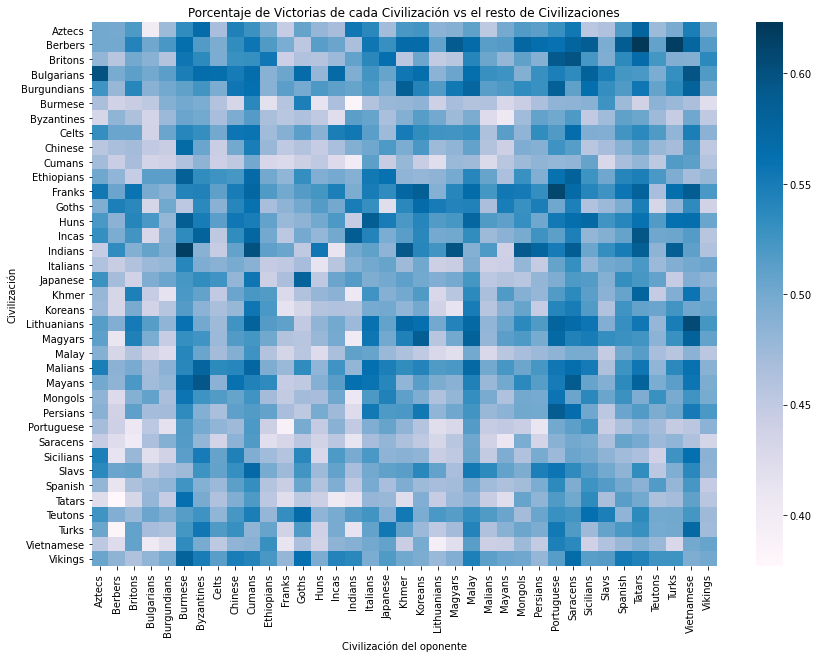

In [41]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10
sns.heatmap(win_vs_singleplayer, cmap="PuBu")
plt.ylabel("Civilización")
plt.xlabel("Civilización del oponente")
plt.title("Porcentaje de Victorias de cada Civilización vs el resto de Civilizaciones")

In [42]:
melted_win_vs_singleplayer = win_vs_singleplayer.unstack().reset_index().rename(columns={0: "win_rate"})
melted_win_vs_singleplayer.sort_values("win_rate").nlargest(10, columns="win_rate").reset_index(drop=True)
melted_win_vs_singleplayer = melted_win_vs_singleplayer[["civ", "opponent_civ", "win_rate"]]
melted_win_vs_singleplayer.nlargest(10, columns="win_rate").reset_index(drop=True)

,civ,opponent_civ,win_rate
0,Berbers,Tatars,0.623041
1,Indians,Burmese,0.617089
2,Berbers,Turks,0.617045
3,Franks,Portuguese,0.609589
4,Lithuanians,Vietnamese,0.605580
5,Indians,Cumans,0.600402
6,Bulgarians,Aztecs,0.599714
7,Britons,Saracens,0.598691
8,Indians,Magyars,0.598039
9,Bulgarians,Vietnamese,0.596675


In [43]:
win_maps_singleplayer = df_singleplayer.pivot_table(values="won", index="civ", columns="map_type")
win_maps_singleplayer.head(10)

map_type,African Clearing,Arabia,Archipelago,Arena,Atacama,Baltic,Crater,Four Lakes,Ghost Lake,Gold Rush,...,Lombardia,MegaRandom,Migration,Mongolia,Nomad,Serengeti,Socotra,Team Islands,Valley,Volcanic Island
civ,,,,,,,,,,,,,,,,,,,,,
Aztecs,0.464935,0.496467,0.485981,0.515611,0.503752,0.520325,0.506876,0.441457,0.494058,0.490942,...,0.488372,0.495902,0.390244,0.544304,0.458333,0.463511,0.516796,0.468354,0.519258,0.509124
Berbers,0.563312,0.533616,0.601351,0.433759,0.562848,0.521092,0.511905,0.534727,0.537109,0.565844,...,0.524590,0.566358,0.519608,0.515789,0.538528,0.550420,0.491607,0.570175,0.534954,0.507761
Britons,0.418836,0.501421,0.422414,0.487467,0.460870,0.485217,0.491436,0.475285,0.523177,0.496304,...,0.474820,0.498790,0.439189,0.526869,0.440358,0.472335,0.472881,0.453988,0.495487,0.510516
Bulgarians,0.532491,0.520031,0.483333,0.525224,0.551451,0.468153,0.534371,0.521040,0.538922,0.531053,...,0.513889,0.530210,0.428571,0.513761,0.513978,0.558179,0.536645,0.475610,0.542816,0.547866
Burgundians,0.522785,0.515105,0.496350,0.556800,0.464993,0.532710,0.477204,0.536070,0.521964,0.540052,...,0.510870,0.531213,0.547009,0.475655,0.478645,0.459302,0.490526,0.388889,0.494530,0.520408
Burmese,0.458967,0.449250,0.333333,0.503990,0.410615,0.472603,0.448980,0.424947,0.417062,0.471042,...,0.428571,0.492813,0.476923,0.441441,0.474114,0.451977,0.441341,0.483871,0.482143,0.532995
Byzantines,0.464534,0.460984,0.547529,0.482860,0.473458,0.528279,0.477509,0.465457,0.447761,0.439807,...,0.555556,0.475282,0.521739,0.479839,0.480692,0.465875,0.480573,0.517572,0.501166,0.441926
Celts,0.508475,0.511111,0.510490,0.515901,0.481271,0.498433,0.508772,0.514653,0.526786,0.529840,...,0.434783,0.495229,0.476190,0.550562,0.500000,0.453333,0.505714,0.378049,0.508353,0.528942
Chinese,0.534024,0.480862,0.445161,0.447194,0.446172,0.510204,0.464072,0.454152,0.463115,0.499350,...,0.515152,0.482265,0.328859,0.465798,0.428714,0.456576,0.453925,0.391753,0.467433,0.488798


Text(0.5, 1.0, 'Porcentaje de Victorias de cada Civilización por Mapa')

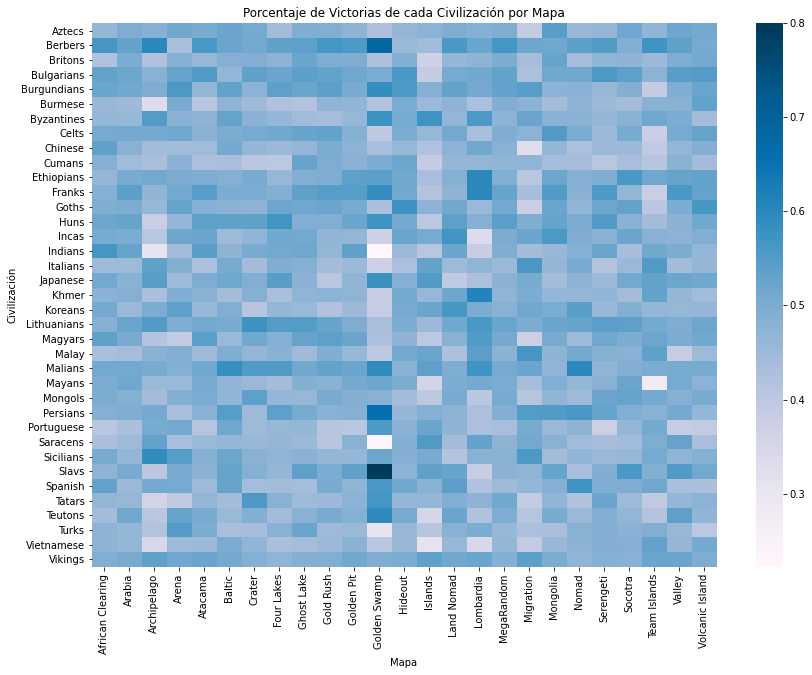

In [44]:
sns.heatmap(win_maps_singleplayer, cmap="PuBu")
plt.ylabel("Civilización")
plt.xlabel("Mapa")
plt.title("Porcentaje de Victorias de cada Civilización por Mapa")

In [45]:
melted_winmap_vs_singleplayer = win_maps_singleplayer.unstack().reset_index().rename(columns={0: "win_rate"})
melted_winmap_vs_singleplayer.sort_values("win_rate").nlargest(10, columns="win_rate").reset_index(drop=True)
melted_winmap_vs_singleplayer = melted_winmap_vs_singleplayer[["civ", "map_type", "win_rate"]]
melted_winmap_vs_singleplayer.nlargest(10, columns="win_rate").reset_index(drop=True)

,civ,map_type,win_rate
0,Slavs,Golden Swamp,0.800000
1,Berbers,Golden Swamp,0.687500
2,Persians,Golden Swamp,0.657143
3,Khmer,Lombardia,0.611111
4,Berbers,Archipelago,0.601351
5,Franks,Lombardia,0.600962
6,Malians,Nomad,0.600402
7,Ethiopians,Lombardia,0.600000
8,Teutons,Golden Swamp,0.592593
9,Malians,Golden Swamp,0.590909


#### ANÁLISIS PARTIDAS MULTIPLAYER.

In [46]:
# Comprobación de valores NaN de cada variable.
df_multiplayer.isna().sum()

match_id                 0
version                  0
map_size                 0
map_type                 0
rating_type              0
server                   0
duration_minutes         0
profile_id               0
player_name            158
country                  0
rating              165779
color                    0
team                     0
civ                      0
won                      0
dtype: int64

In [47]:
df_multiplayer.describe()

,match_id,version,duration_minutes,profile_id,rating,team,won
count,3.623748e+06,3623748.0,3.623748e+06,3.623748e+06,3.457969e+06,3623748.0,3623748.0
mean,9.573848e+07,47820.0,3.103638e+01,2.804719e+06,1.684954e+03,1.5,0.5
std,3.970090e+06,0.0,1.667614e+01,1.781339e+06,5.168304e+02,0.5,0.5
min,8.892465e+07,47820.0,0.000000e+00,1.320000e+02,-3.200000e+01,1.0,0.0
25%,9.225763e+07,47820.0,2.200000e+01,1.301053e+06,1.284000e+03,1.0,0.0
50%,9.565776e+07,47820.0,3.000000e+01,2.605089e+06,1.615000e+03,1.5,0.5
75%,9.921177e+07,47820.0,3.700000e+01,4.392952e+06,2.064000e+03,2.0,1.0
max,1.026705e+08,47820.0,2.400000e+02,6.079756e+06,4.043000e+03,2.0,1.0


Text(0.5, 0, 'ELO')

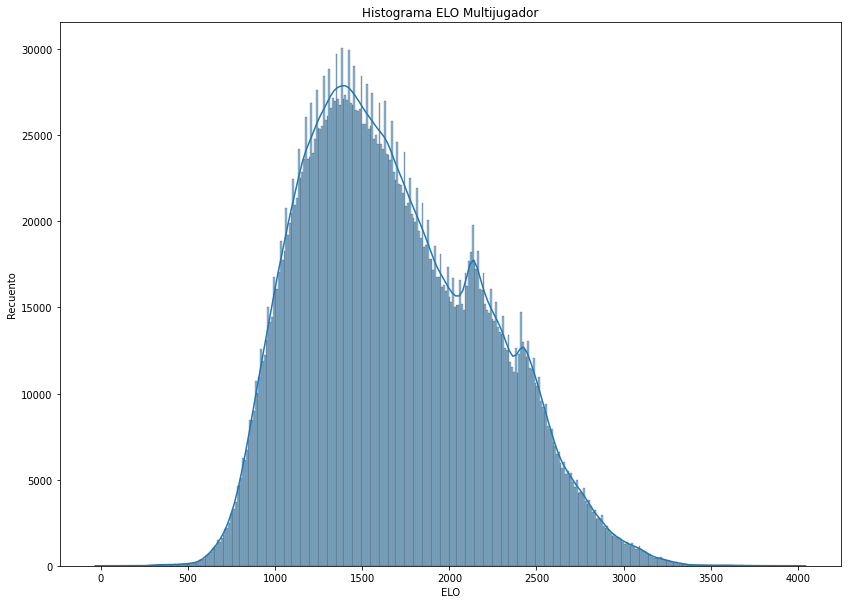

In [48]:
ax = sns.histplot(df_multiplayer.rating, stat="count", kde=True)
ax.set_title('Histograma ELO Multijugador')
ax.set_ylabel('Recuento')
ax.set_xlabel('ELO')

<AxesSubplot:xlabel='rating'>

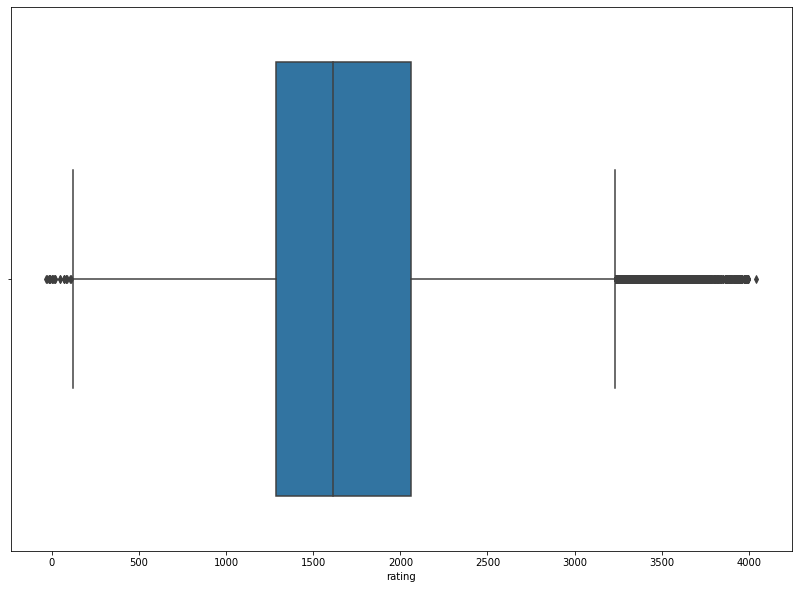

In [49]:
sns.boxplot(df_multiplayer.rating)

Text(0.5, 0, 'Duración en minutos')

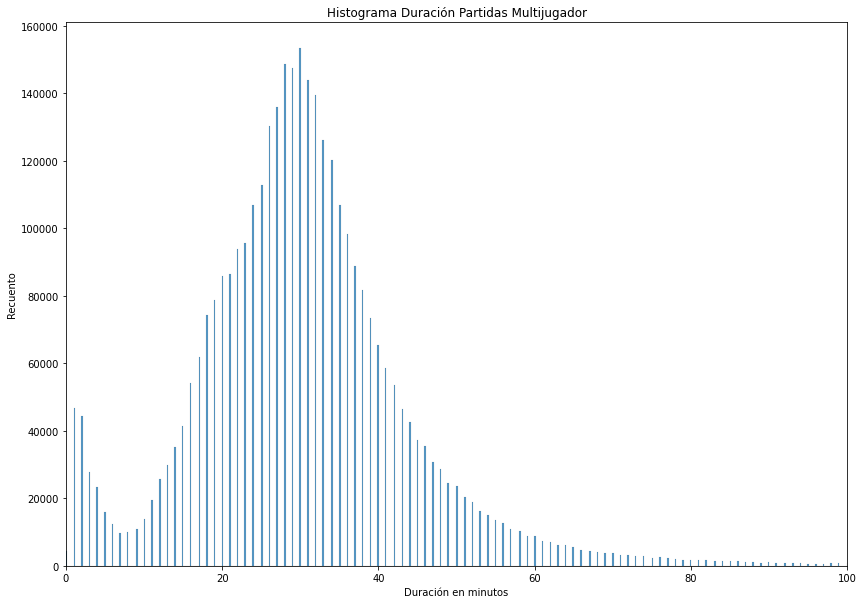

In [50]:
ax = sns.histplot(df_multiplayer.duration_minutes)
plt.xlim(0, 100)
ax.set_title('Histograma Duración Partidas Multijugador')
ax.set_ylabel('Recuento')
ax.set_xlabel('Duración en minutos')

(0.0, 100.0)

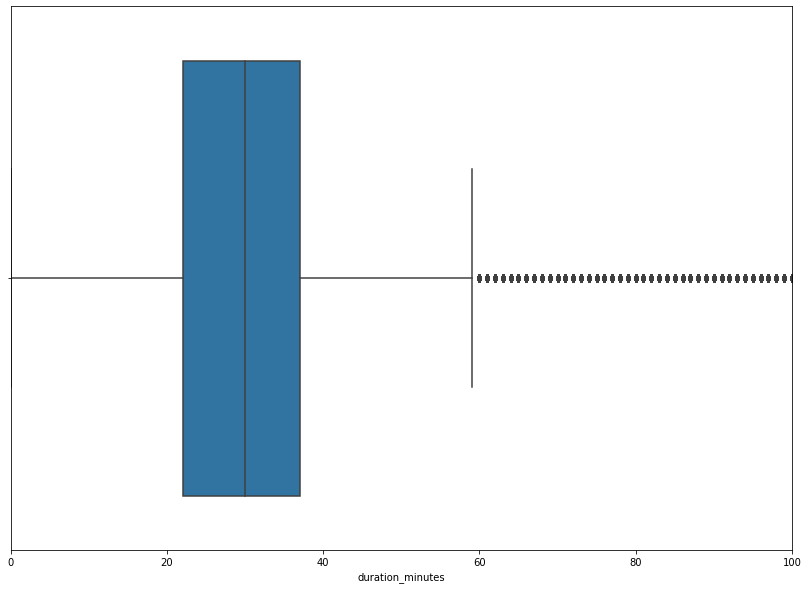

In [51]:
sns.boxplot(df_multiplayer.duration_minutes)
plt.xlim(0, 100)

Text(0.5, 1.0, '% de Uso de Civilizaciones en partidas multijugador')

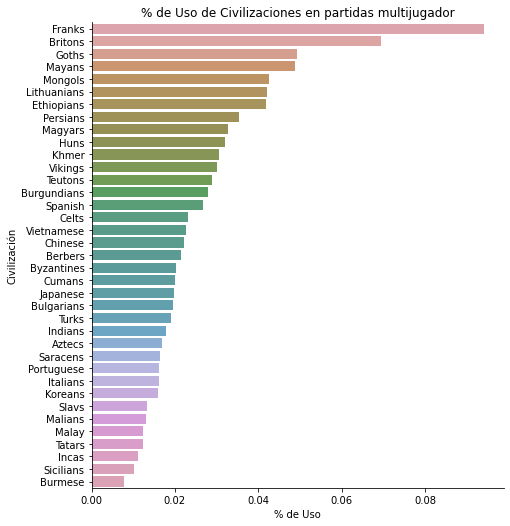

In [52]:
sns.catplot(y="civ", x="frequency",  data=frequency_civs_multiplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Civilización")
plt.xlabel("% de Uso")
plt.title("% de Uso de Civilizaciones en partidas multijugador")

Text(0.5, 1.0, 'Porcentaje de Victorias de Civilizaciones en partidas multijugador')

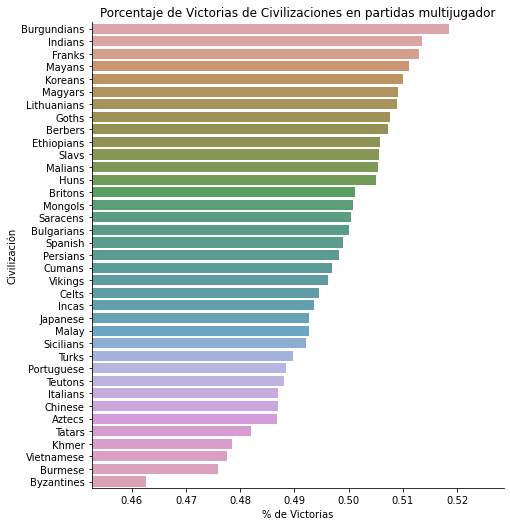

In [53]:
sns.catplot(y="civ", x="win_rate",  data=win_rate_civs_multiplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Civilización")
plt.xlabel("% de Victorias")
lim_sup = float(win_rate_civs_multiplayer.win_rate.head(1) + 0.01)
lim_inf = float(win_rate_civs_multiplayer.win_rate.tail(1) - 0.01)
plt.xlim(lim_inf, lim_sup)
plt.title("Porcentaje de Victorias de Civilizaciones en partidas multijugador")

Text(0.5, 1.0, '% de Partidas por Mapa en partidas multijugador')

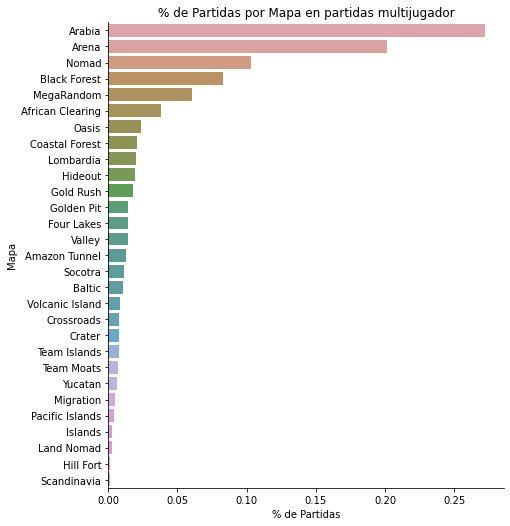

In [54]:
sns.catplot(y="map", x="frequency",  data=frequency_maps_multiplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Mapa")
plt.xlabel("% de Partidas")
plt.title("% de Partidas por Mapa en partidas multijugador")

Text(0.5, 1.0, '% de Partidas por Color en partidas multijugador')

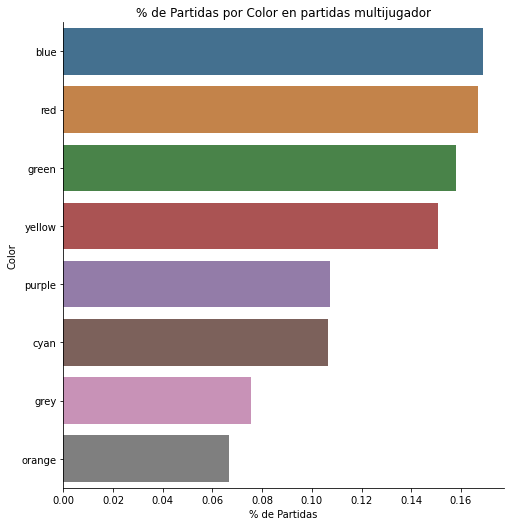

In [55]:
sns.catplot(y="color", x="frequency",  data=frequency_color_multiplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Color")
plt.xlabel("% de Partidas")
plt.title("% de Partidas por Color en partidas multijugador")

Text(0.5, 1.0, '% de Partidas por Servidor en partidas multijugador')

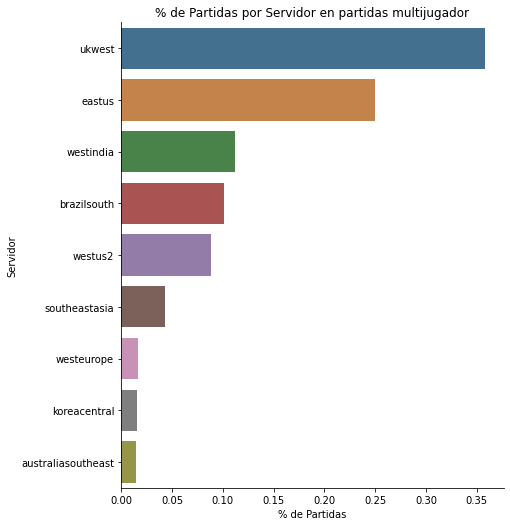

In [56]:
sns.catplot(y="server", x="frequency",  data=frequency_server_multiplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Servidor")
plt.xlabel("% de Partidas")
plt.title("% de Partidas por Servidor en partidas multijugador")

Text(0.5, 1.0, '% de Partidas por Nacionalidad en partidas multijugador')

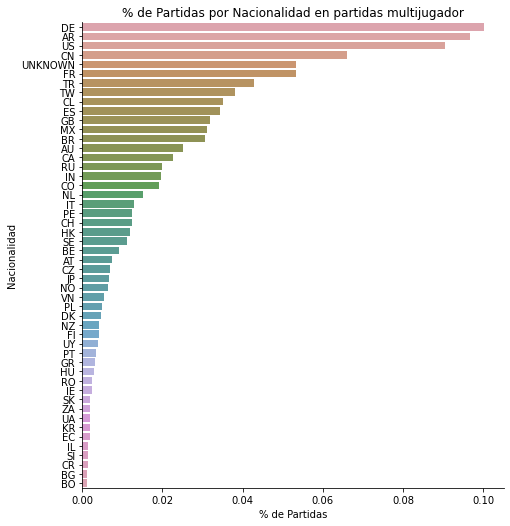

In [57]:
frequency_country_multiplayer = frequency_country_multiplayer.head(50)
sns.catplot(y="country", x="frequency",  data=frequency_country_multiplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Nacionalidad")
plt.xlabel("% de Partidas")
plt.title("% de Partidas por Nacionalidad en partidas multijugador")

In [58]:
renames_multiplayer = {
    "profile_id": "opponent",
    "civ": "opponent_civ",
}
opponents_multiplayer = df_multiplayer[["match_id", "profile_id", "civ"]].rename(columns=renames_multiplayer)
vs_df_multiplayer = pd.merge(df_multiplayer, opponents_multiplayer, left_on="match_id", right_on="match_id").rename(columns={"profile_id": "player"})

# Dado que hemos fusionado el mismo marco de datos un jugador será un oponente de sí mismo, debemos eliminar esas filas.
vs_df_multiplayer = vs_df_multiplayer[vs_df_multiplayer["player"] != vs_df_multiplayer["opponent"]]
vs_df_multiplayer = vs_df_multiplayer[["match_id", "player", "opponent", "civ", "opponent_civ", "won"]]

In [59]:
# Matriz cuadrada del porcentaje de victorias de civilizaciones vs el resto de civilizaciones.
win_vs_multiplayer = vs_df_multiplayer.pivot_table(values="won", index="civ", columns="opponent_civ")
win_vs_multiplayer.head(10)

opponent_civ,Aztecs,Berbers,Britons,Bulgarians,Burgundians,Burmese,Byzantines,Celts,Chinese,Cumans,...,Portuguese,Saracens,Sicilians,Slavs,Spanish,Tatars,Teutons,Turks,Vietnamese,Vikings
civ,,,,,,,,,,,,,,,,,,,,,
Aztecs,0.492090,0.483032,0.481081,0.490810,0.489029,0.473949,0.497667,0.491576,0.488940,0.486607,...,0.480607,0.479840,0.489193,0.495561,0.491765,0.481547,0.492396,0.493147,0.490241,0.471896
Berbers,0.518057,0.498480,0.501866,0.505849,0.505161,0.522295,0.510133,0.500274,0.507111,0.505837,...,0.511380,0.507812,0.510215,0.495178,0.512552,0.513494,0.505053,0.501451,0.518515,0.515618
Britons,0.502667,0.508325,0.496549,0.500291,0.499645,0.505542,0.507286,0.499351,0.507182,0.496014,...,0.499772,0.507381,0.496866,0.504617,0.491717,0.505465,0.501817,0.493067,0.499920,0.505468
Bulgarians,0.511838,0.486305,0.495927,0.514125,0.496863,0.516281,0.511818,0.513383,0.512599,0.508222,...,0.512644,0.501538,0.502615,0.500408,0.495429,0.495767,0.505648,0.509829,0.497788,0.491533
Burgundians,0.537367,0.506594,0.521213,0.515579,0.501349,0.527764,0.529915,0.519173,0.522782,0.519954,...,0.522015,0.510918,0.523425,0.521739,0.516517,0.528062,0.523851,0.522488,0.516182,0.516990
Burmese,0.484369,0.457968,0.465506,0.485733,0.474184,0.486076,0.492357,0.479650,0.481807,0.479209,...,0.488728,0.467473,0.488485,0.472457,0.482047,0.466395,0.482273,0.483276,0.474765,0.487121
Byzantines,0.472226,0.467269,0.455264,0.468417,0.457784,0.466242,0.487948,0.467183,0.471873,0.475207,...,0.478368,0.463101,0.453669,0.455412,0.478990,0.472082,0.474178,0.455714,0.467259,0.479810
Celts,0.500876,0.495752,0.488677,0.489489,0.493853,0.497424,0.499278,0.497066,0.500776,0.497161,...,0.498529,0.496336,0.488680,0.510779,0.503393,0.505885,0.503541,0.496213,0.509547,0.486354
Chinese,0.481518,0.485423,0.487708,0.480922,0.491295,0.500606,0.493834,0.487217,0.486733,0.491352,...,0.480014,0.486974,0.489502,0.485816,0.491352,0.491577,0.496919,0.478402,0.489713,0.487925


Text(0.5, 1.0, 'Porcentajde de Victorias de cada Civilización vs el resto de Civilizaciones')

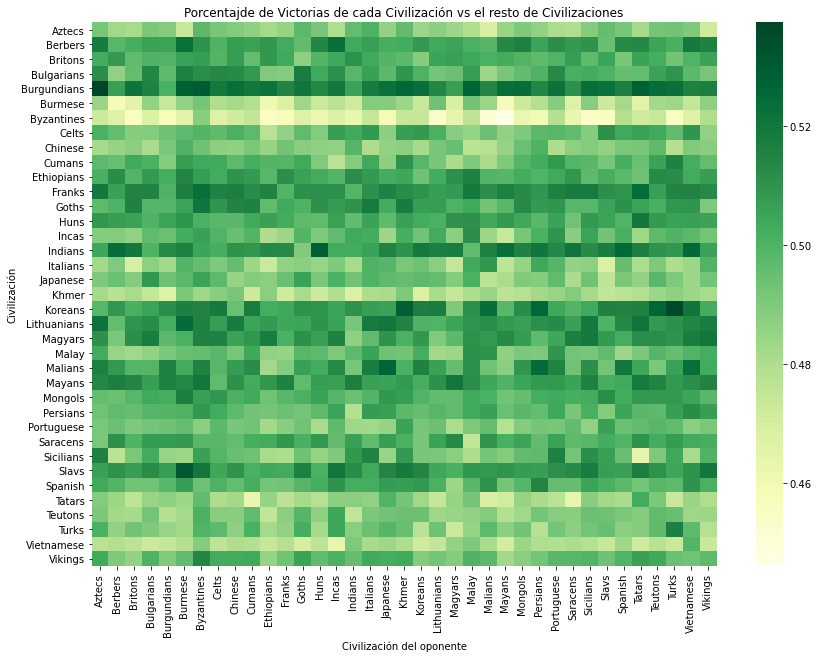

In [60]:
sns.heatmap(win_vs_multiplayer,  cmap="YlGn")
plt.ylabel("Civilización")
plt.xlabel("Civilización del oponente")
plt.title("Porcentajde de Victorias de cada Civilización vs el resto de Civilizaciones")

In [61]:
melted_win_vs_multiplayer = win_vs_multiplayer.unstack().reset_index().rename(columns={0: "win_rate"})
melted_win_vs_multiplayer.sort_values("win_rate").nlargest(10, columns="win_rate").reset_index(drop=True)
melted_win_vs_multiplayer = melted_win_vs_multiplayer[["civ", "opponent_civ", "win_rate"]]
melted_win_vs_multiplayer.nlargest(10, columns="win_rate").reset_index(drop=True)

,civ,opponent_civ,win_rate
0,Burgundians,Aztecs,0.537367
1,Koreans,Turks,0.536193
2,Slavs,Burmese,0.531162
3,Burgundians,Byzantines,0.529915
4,Indians,Huns,0.529036
5,Koreans,Khmer,0.528261
6,Burgundians,Tatars,0.528062
7,Burgundians,Burmese,0.527764
8,Burgundians,Malay,0.526851
9,Malians,Japanese,0.526826


In [62]:
win_maps_multiplayer = df_multiplayer.pivot_table(values="won", index="civ", columns="map_type")
win_maps_multiplayer.head(10)

map_type,African Clearing,Amazon Tunnel,Arabia,Arena,Baltic,Black Forest,Coastal Forest,Crater,Crossroads,Four Lakes,...,Nomad,Oasis,Pacific Islands,Scandinavia,Socotra,Team Islands,Team Moats,Valley,Volcanic Island,Yucatan
civ,,,,,,,,,,,,,,,,,,,,,
Aztecs,0.498700,0.466572,0.477986,0.501920,0.505470,0.486687,0.476043,0.504559,0.456790,0.488712,...,0.486476,0.483848,0.390000,0.442308,0.484290,0.400000,0.463357,0.484813,0.477113,0.467167
Berbers,0.527314,0.450673,0.510015,0.466632,0.529801,0.454783,0.536028,0.502530,0.512862,0.516408,...,0.521495,0.513200,0.490909,0.566667,0.457655,0.485795,0.495345,0.524664,0.522606,0.508911
Britons,0.485454,0.504542,0.512450,0.483998,0.494643,0.494849,0.505847,0.534700,0.520548,0.500172,...,0.459464,0.519015,0.443213,0.547414,0.514502,0.490000,0.502604,0.507901,0.533999,0.516603
Bulgarians,0.495409,0.474576,0.484301,0.515565,0.532847,0.517483,0.496586,0.495695,0.472178,0.503876,...,0.500379,0.522114,0.451923,0.569231,0.511416,0.493274,0.508800,0.515152,0.487117,0.531807
Burgundians,0.526702,0.468933,0.515572,0.528789,0.526642,0.503440,0.521593,0.511799,0.516373,0.507054,...,0.513402,0.510763,0.458599,0.472973,0.496324,0.525896,0.513732,0.523836,0.516896,0.512381
Burmese,0.465533,0.500000,0.453081,0.498812,0.469697,0.454680,0.479675,0.448485,0.450777,0.433735,...,0.498184,0.452297,0.428571,0.500000,0.567460,0.454545,0.467742,0.445902,0.421488,0.496503
Byzantines,0.459759,0.420021,0.434602,0.473356,0.475186,0.470410,0.433041,0.455556,0.479574,0.468809,...,0.472596,0.470927,0.541322,0.389831,0.446429,0.524636,0.449219,0.476923,0.455235,0.447942
Celts,0.484615,0.520113,0.468622,0.511684,0.510417,0.509485,0.450192,0.451128,0.504188,0.445701,...,0.504739,0.479082,0.384000,0.483333,0.482609,0.480176,0.511677,0.452292,0.495066,0.522782
Chinese,0.507126,0.429599,0.489972,0.483358,0.510730,0.478501,0.501451,0.482578,0.477636,0.493292,...,0.472898,0.472249,0.414201,0.424242,0.464088,0.476667,0.464407,0.513962,0.491848,0.450413


Text(0.5, 1.0, 'Porcentajde de Victorias de cada Civilización por Mapa')

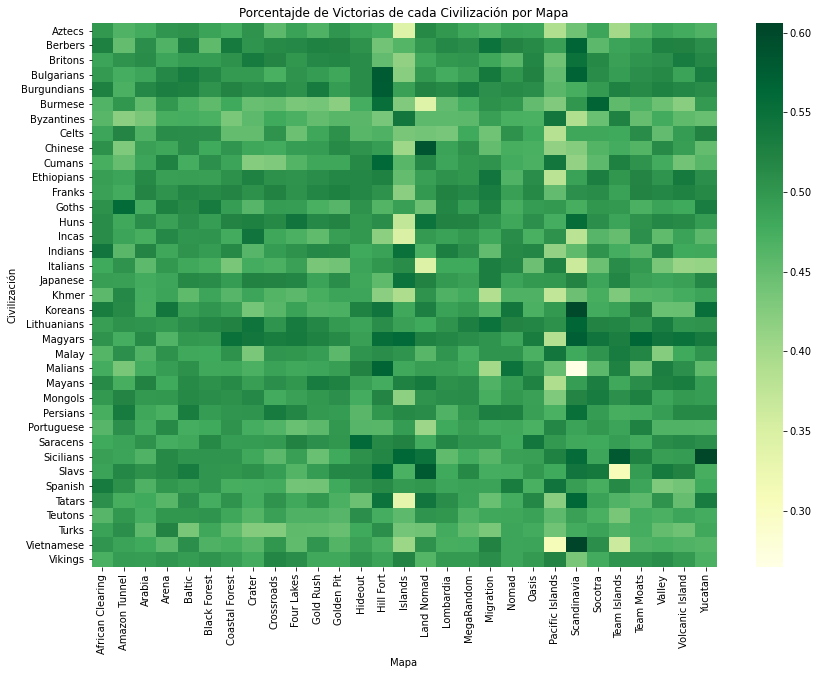

In [63]:
sns.heatmap(win_maps_multiplayer,  cmap="YlGn")
plt.ylabel("Civilización")
plt.xlabel("Mapa")
plt.title("Porcentajde de Victorias de cada Civilización por Mapa")

In [64]:
melted_winmap_vs_multiplayer = win_maps_multiplayer.unstack().reset_index().rename(columns={0: "win_rate"})
melted_winmap_vs_multiplayer.sort_values("win_rate").nlargest(10, columns="win_rate").reset_index(drop=True)
melted_winmap_vs_multiplayer = melted_winmap_vs_multiplayer[["civ", "map_type", "win_rate"]]
melted_winmap_vs_multiplayer.nlargest(10, columns="win_rate").reset_index(drop=True)

,civ,map_type,win_rate
0,Vietnamese,Scandinavia,0.606061
1,Sicilians,Yucatan,0.603175
2,Koreans,Scandinavia,0.600000
3,Chinese,Land Nomad,0.585470
4,Sicilians,Team Islands,0.581176
5,Slavs,Land Nomad,0.579439
6,Bulgarians,Hill Fort,0.578125
7,Burgundians,Hill Fort,0.577922
8,Magyars,Scandinavia,0.572917
9,Bulgarians,Scandinavia,0.569231
